## Models for Original Audios

In [53]:
#Importing the required libraries
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import fftpack
from scipy.stats import kurtosis,skew,mode
import sklearn.preprocessing,sklearn.decomposition
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,train_test_split
from keras import utils
import keras
from sklearn.decomposition import PCA
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten,Reshape, BatchNormalization, ZeroPadding2D,MaxPooling1D,AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers,optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [54]:
df = pd.read_csv(r"C:\Users\pavan\Documents\Fall 2024\EE502 ML in Bio\Final Project\SWC\language_features.csv")

In [55]:
df

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,Chroma_10,Chroma_11,SpectralContrast_0,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,Label
0,-481.751282,101.014961,-7.370456,21.011026,11.820652,-5.823113,-7.208418,-1.639658,-9.234241,-2.033903,...,0.511279,0.481678,17.389723,9.665587,12.711685,13.156577,17.081439,22.944283,42.031040,Dutch
1,-355.555359,100.489540,26.064215,42.599300,21.112593,15.803838,4.642409,9.552911,-2.831193,8.441623,...,0.785947,0.720931,9.259313,6.945292,9.818391,11.259890,13.109528,16.916209,37.991576,Dutch
2,-494.728485,97.049171,-5.943329,22.197573,13.259092,-6.565980,-3.329051,0.884476,-13.324694,-1.061518,...,0.556531,0.563684,17.660488,9.806260,12.305297,12.708329,16.309950,21.774346,41.380397,Dutch
3,-353.211548,102.637695,27.485174,47.475529,24.500154,14.251774,1.510977,4.879726,-1.098654,9.034349,...,0.779655,0.723628,9.191273,6.845349,10.263353,11.030561,13.637188,16.902319,37.185443,Dutch
4,-473.017883,107.046059,-8.093265,26.144173,13.502638,-7.952041,-8.666633,-4.238086,-12.634802,-1.816826,...,0.492018,0.502157,17.827660,9.413820,13.027685,13.163255,16.825848,24.021220,44.314994,Dutch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644,-441.428864,95.669502,32.085533,34.698902,20.461151,-0.475378,8.035894,-3.620089,-3.110109,-3.639597,...,0.695217,0.698840,11.728764,10.329983,12.334888,12.719680,15.502206,20.461433,35.440421,German
2645,-454.606873,85.218689,27.676006,24.765591,14.181431,12.457692,-17.883406,-1.003497,-6.397526,-2.016774,...,0.596567,0.571909,11.238386,6.488327,11.187408,12.119758,16.856789,19.110739,41.296085,German
2646,-464.066772,82.006477,28.987843,23.478230,15.306504,10.379747,-15.582608,-0.790893,-7.390070,-2.890126,...,0.626962,0.596748,11.151246,6.709475,11.221020,11.806763,15.774451,18.755532,39.549192,German
2647,-470.648743,79.966324,28.612371,24.228798,14.908826,10.501396,-15.625713,-1.218402,-6.861120,-4.063834,...,0.601797,0.585980,11.345039,6.629659,11.267346,11.720325,15.722433,18.729630,39.627918,German


### Visualizing the Classification of Audios

Total audio samples: 2649
Label
Dutch      917
German     894
English    838
Name: count, dtype: int64


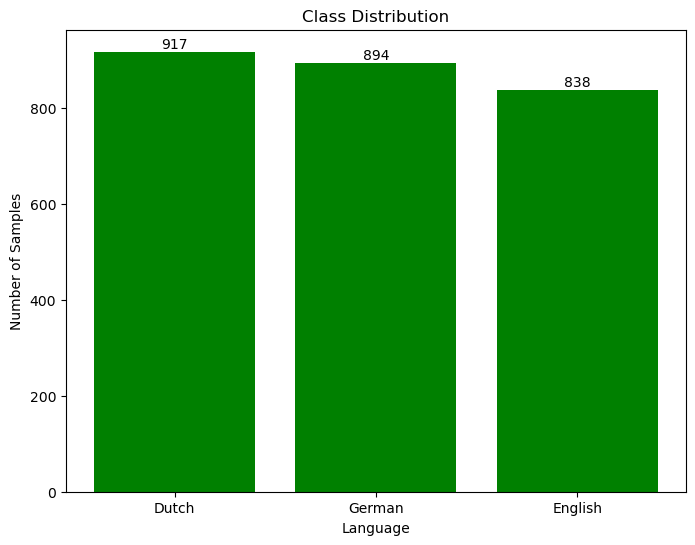

In [56]:

# Check class distribution
class_counts = df['Label'].value_counts()
total_samples = class_counts.sum()
print(f'Total audio samples: {total_samples:}')
print(class_counts)

# Plot the class distribution with counts on top
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='Green')
plt.title('Class Distribution')
plt.xlabel('Language')
plt.ylabel('Number of Samples')

# Add counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

plt.show()


### Preprocessing and Normalization

In [57]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop the specified columns correctly
X = df.drop(columns=["Label"])
y = df["Label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize and apply the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the features


### Splitting the dataset
#### Test size 30% and Train size 70%

In [58]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

### PCA

In [59]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=10)  # Adjust 'n_components' as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)



### Random Forest Model with PCA

Random Forest F1 Score: 0.79
Best Parameters from Grid Search: {'max_depth': None, 'n_estimators': 100}
Accuracy with All Features: 0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       275
           1       0.67      0.78      0.72       258
           2       0.76      0.73      0.74       262

    accuracy                           0.79       795
   macro avg       0.80      0.79      0.79       795
weighted avg       0.80      0.79      0.79       795



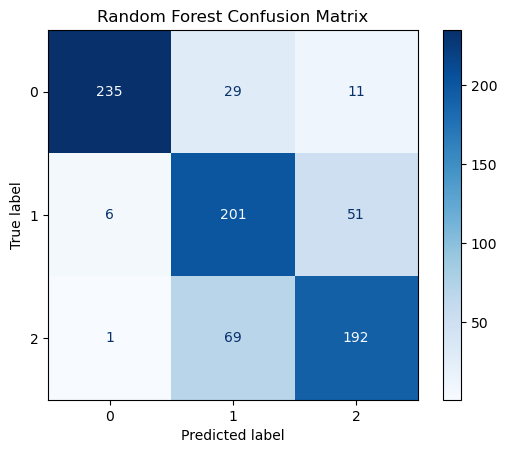

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Grid Search
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Grid Search with Random Forest
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1_weighted', cv=3)
grid_search_rf.fit(X_train_pca, y_train)

# Train with best RF parameters
best_rf = grid_search_rf.best_estimator_
rf_pred = best_rf.predict(X_test_pca)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
accuracy_rf = accuracy_score(y_test, rf_pred)

print(f"Random Forest F1 Score: {rf_f1:.2f}")
print(f"Best Parameters from Grid Search: {grid_search_rf.best_params_}")
print(f"Accuracy with All Features: {accuracy_rf:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_conf_matrix).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

### Random Forest Model

Random Forest F1 Score: 0.85
Best Parameters from Grid Search: {'max_depth': 20, 'n_estimators': 100}
Accuracy with All Features: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       275
           1       0.76      0.84      0.80       258
           2       0.80      0.81      0.81       262

    accuracy                           0.85       795
   macro avg       0.85      0.85      0.85       795
weighted avg       0.85      0.85      0.85       795



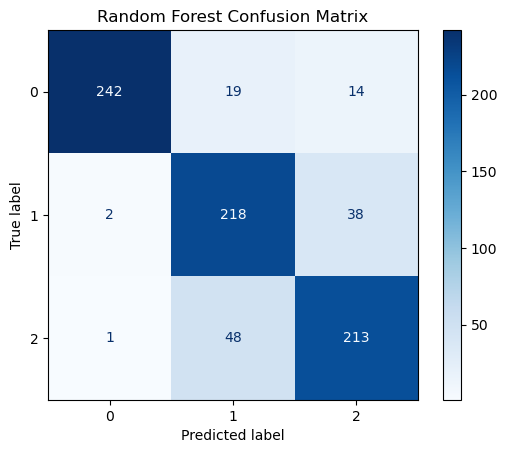

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Grid Search
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Grid Search with Random Forest
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='f1_weighted', cv=3)
grid_search_rf.fit(X_train, y_train)

# Train with best RF parameters
best_rf = grid_search_rf.best_estimator_
rf_pred = best_rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
accuracy_rf = accuracy_score(y_test, rf_pred)

print(f"Random Forest F1 Score: {rf_f1:.2f}")
print(f"Best Parameters from Grid Search: {grid_search_rf.best_params_}")
print(f"Accuracy with All Features: {accuracy_rf:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(rf_conf_matrix).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

### Feature Importance Analysis


Top 10 Features by Importance:
               Feature  Importance
25  SpectralContrast_0    0.112097
11             MFCC_11    0.060356
26  SpectralContrast_1    0.060133
2               MFCC_2    0.052256
12             MFCC_12    0.036723
0               MFCC_0    0.033589
29  SpectralContrast_4    0.033496
30  SpectralContrast_5    0.033136
5               MFCC_5    0.032544
9               MFCC_9    0.032352

Random Forest F1 Score with Top Features: 0.83
Accuracy with Top Features: 0.83

Classification Report (Top Features):
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       275
           1       0.74      0.81      0.78       258
           2       0.78      0.79      0.78       262

    accuracy                           0.83       795
   macro avg       0.83      0.82      0.83       795
weighted avg       0.83      0.83      0.83       795



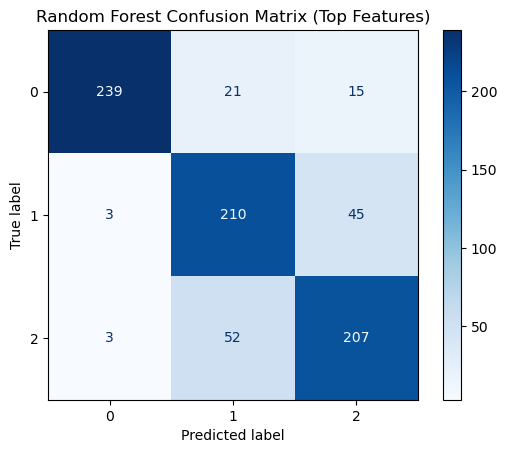

In [62]:
# Extract feature importances
feature_importances = best_rf.feature_importances_

# Assuming X_train was originally a DataFrame
feature_names = list(X.columns) if isinstance(X, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the top features
print("\nTop 10 Features by Importance:")
print(feature_importance_df.head(10))

# Select Top Features
top_features = feature_importance_df['Feature'].head(18).values  # Adjust '10' to the desired number of top features

# Convert top feature names to indices if needed
if isinstance(X_train, pd.DataFrame):
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]
else:  # For NumPy arrays
    top_features_indices = [feature_names.index(f) for f in top_features]
    X_train_top = X_train[:, top_features_indices]
    X_test_top = X_test[:, top_features_indices]

# Train a new Random Forest model with top-ranked features
rf_top = RandomForestClassifier(random_state=42, **grid_search_rf.best_params_)
rf_top.fit(X_train_top, y_train)
rf_pred_top = rf_top.predict(X_test_top)

# Evaluate the new model
rf_f1_top = f1_score(y_test, rf_pred_top, average='weighted')
accuracy_rf_top = accuracy_score(y_test, rf_pred_top)

print(f"\nRandom Forest F1 Score with Top Features: {rf_f1_top:.2f}")
print(f"Accuracy with Top Features: {accuracy_rf_top:.2f}")
print("\nClassification Report (Top Features):")
print(classification_report(y_test, rf_pred_top))

# Confusion Matrix for top features
rf_conf_matrix_top = confusion_matrix(y_test, rf_pred_top)
ConfusionMatrixDisplay(rf_conf_matrix_top).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix (Top Features)")
plt.show()


### SVM Model

Best Parameters from Grid Search: {'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.74
F1 Score: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       275
           1       0.68      0.68      0.68       258
           2       0.72      0.74      0.73       262

    accuracy                           0.74       795
   macro avg       0.74      0.74      0.74       795
weighted avg       0.75      0.74      0.75       795



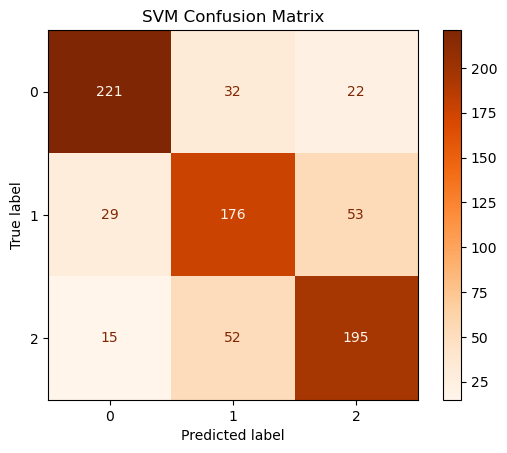

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Grid Search
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Grid Search with SVM
svm = SVC()
grid_search_svm = GridSearchCV(svm, param_grid_svm, scoring='f1', cv=3)
grid_search_svm.fit(X_train, y_train)

# Train with best SVM parameters
best_svm = grid_search_svm.best_estimator_
svm_pred = best_svm.predict(X_test)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

# Evaluate the model
accuracy_svm = accuracy_score(y_test, svm_pred)

print(f"Best Parameters from Grid Search: {grid_search_svm.best_params_}")
print(f"Accuracy: {accuracy_svm:.2f}")
print(f"F1 Score: {svm_f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred))
svm_conf_matrix = confusion_matrix(y_test, svm_pred)

# Plot the confusion matrix
ConfusionMatrixDisplay(svm_conf_matrix).plot(cmap='Oranges')
plt.title("SVM Confusion Matrix")
plt.show()


### HMM Model

Starting Grid Search...
Training with params: n_components=3, covariance_type=diag, n_iter=50
Training with params: n_components=3, covariance_type=diag, n_iter=100
Training with params: n_components=3, covariance_type=full, n_iter=50
Training with params: n_components=3, covariance_type=full, n_iter=100

Best Parameters Found:
{'n_components': 3, 'covariance_type': 'diag', 'n_iter': 100}
Best F1-Score: 0.2460

HMM Model Performance with Best Parameters:
F1-Score: 0.2460
Accuracy: 0.30

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.03      0.06       275
           1       0.38      0.24      0.29       258
           2       0.29      0.65      0.40       262

    accuracy                           0.30       795
   macro avg       0.28      0.31      0.25       795
weighted avg       0.28      0.30      0.25       795



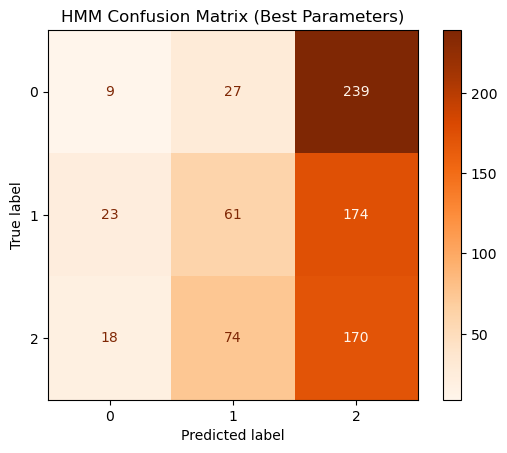

In [64]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import product

# Ensure X_train and X_test are already loaded and structured correctly.
# y_train and y_test should be the corresponding labels.

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 3: Flatten X_train and X_test into a single sequence for HMM
X_train_seq = np.concatenate(X_train_scaled).reshape(-1, 1)
X_test_seq = np.concatenate(X_test_scaled).reshape(-1, 1)

# Step 4: Define lengths for each sequence in the training and test sets
train_lengths = [X_train.shape[1]] * X_train.shape[0]  # Assuming equal-length sequences in training data
test_lengths = [X_test.shape[1]] * X_test.shape[0]  # Assuming equal-length sequences in test data

# Step 5: Define parameter grid for HMM
param_grid = {
    'n_components': [3],  # Number of hidden states
    'covariance_type': ['diag', 'full'],  # Covariance type
    'n_iter': [50, 100]  # Number of iterations
}

best_score = -np.inf
best_params = None
best_model = None

# Step 6: Perform Grid Search
print("Starting Grid Search...")
for n_components, covariance_type, n_iter in product(param_grid['n_components'], param_grid['covariance_type'], param_grid['n_iter']):
    print(f"Training with params: n_components={n_components}, covariance_type={covariance_type}, n_iter={n_iter}")
    hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type, n_iter=n_iter, random_state=42)
    try:
        hmm_model.fit(X_train_seq, lengths=train_lengths)
        # Predict and evaluate on the training set (cross-validation can be added for more robust tuning)
        hmm_predictions = hmm_model.predict(X_test_seq, lengths=test_lengths)
        
        # Aggregate predictions for each sequence
        split_indices = np.cumsum(test_lengths[:-1])  # Determine split points
        grouped_predictions = np.split(hmm_predictions, split_indices)
        aggregated_predictions = [np.bincount(group).argmax() for group in grouped_predictions]
        
        # Evaluate the F1-score
        hmm_f1 = f1_score(y_test_encoded, aggregated_predictions, average='weighted')
        
        if hmm_f1 > best_score:
            best_score = hmm_f1
            best_params = {
                'n_components': n_components,
                'covariance_type': covariance_type,
                'n_iter': n_iter
            }
            best_model = hmm_model
    except Exception as e:
        print(f"Error with params {n_components, covariance_type, n_iter}: {e}")
        continue

print("\nBest Parameters Found:")
print(best_params)
print(f"Best F1-Score: {best_score:.4f}")

# Step 7: Evaluate the Best Model
if best_model is not None:
    hmm_predictions = best_model.predict(X_test_seq, lengths=test_lengths)
    
    # Aggregate predictions for each sequence
    split_indices = np.cumsum(test_lengths[:-1])
    grouped_predictions = np.split(hmm_predictions, split_indices)
    aggregated_predictions = [np.bincount(group).argmax() for group in grouped_predictions]
    
    # Ensure predictions align with the number of test samples
    assert len(aggregated_predictions) == len(y_test_encoded)
    
    # Metrics
    accuracy_hmm = accuracy_score(y_test_encoded, aggregated_predictions)
    
    print("\nHMM Model Performance with Best Parameters:")
    print(f"F1-Score: {best_score:.4f}")
    print(f"Accuracy: {accuracy_hmm:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, aggregated_predictions, target_names=list(map(str, label_encoder.classes_))))
    
    # Confusion Matrix
    hmm_conf_matrix = confusion_matrix(y_test_encoded, aggregated_predictions)
    ConfusionMatrixDisplay(hmm_conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Oranges')
    plt.title("HMM Confusion Matrix (Best Parameters)")
    plt.show()
else:
    print("No valid model found during grid search.")


#### Comparision Table

In [65]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score"],
    "SVM": [accuracy_svm, svm_f1],
    "Random Forest": [accuracy_rf, rf_f1],
    "HMM": [accuracy_hmm, hmm_f1]
})

print("\nComparison Table:")
print(comparison_df)



Comparison Table:
     Metric       SVM  Random Forest       HMM
0  Accuracy  0.744654       0.846541  0.301887
1  F1 Score  0.745259       0.848942  0.246030


### Statstical Tests

#### ANOVA Test on models

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from hmmlearn import hmm
from scipy.stats import f_oneway, ttest_rel
import numpy as np
import pandas as pd

# Prepare the data (assuming X_scaled and y_encoded are already preprocessed)
X = X_scaled  # Scaled features
y = y_encoded  # Labels (encoded as integers)

# Initialize Stratified K-Fold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store F1-scores for statistical comparison
rf_f1_scores = []
svm_f1_scores = []

# Loop through each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_f1_scores.append(f1_score(y_test, rf_pred, average='weighted'))
    
    # SVM
    svm = SVC(C=10, kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_f1_scores.append(f1_score(y_test, svm_pred, average='weighted'))
    

# Combine F1-scores into a DataFrame for statistical analysis
f1_scores_df = pd.DataFrame({
    'Random Forest': rf_f1_scores,
    'SVM': svm_f1_scores,
})

# Display F1-scores from all folds
print("\nF1-Scores for Each Model Across Folds:")
print(f1_scores_df)

# Perform statistical comparisons
# ANOVA test to compare the mean F1-scores
anova_result = f_oneway(f1_scores_df['Random Forest'], f1_scores_df['SVM'])
print(f"\nANOVA Test:\nF-statistic = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4f}")




F1-Scores for Each Model Across Folds:
   Random Forest       SVM
0       0.836219  0.828817
1       0.848088  0.855575
2       0.842453  0.858588
3       0.826580  0.885444
4       0.827541  0.840469

ANOVA Test:
F-statistic = 2.8463, p-value = 0.1301


#### CHI-Square Test on Features

In [67]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import KBinsDiscretizer

# Separate features and labels
X = df.drop(columns=['Label'])
y = df['Label']

# Discretize numerical features into categorical bins
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_binned = kbins.fit_transform(X)

# Perform Chi-Square test
chi2_scores, p_values = chi2(X_binned, y)

# Create a DataFrame for better readability
chi2_results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
})

# Display results
# Display the Chi-Square test results
print(chi2_results)



               Feature  Chi2 Score        p-value
0               MFCC_0   25.609897   2.747145e-06
1               MFCC_1   19.079235   7.194435e-05
2               MFCC_2   89.317419   4.026881e-20
3               MFCC_3   53.471515   2.447981e-12
4               MFCC_4   11.937827   2.557019e-03
5               MFCC_5   89.055969   4.589253e-20
6               MFCC_6   44.852769   1.821146e-10
7               MFCC_7    9.330423   9.417258e-03
8               MFCC_8   38.314970   4.786411e-09
9               MFCC_9   19.178584   6.845787e-05
10             MFCC_10   56.850285   4.519781e-13
11             MFCC_11  225.816048   9.218669e-50
12             MFCC_12   54.024594   1.856557e-12
13            Chroma_0   25.698354   2.628290e-06
14            Chroma_1    8.028275   1.805852e-02
15            Chroma_2   10.323651   5.731227e-03
16            Chroma_3   15.870585   3.578873e-04
17            Chroma_4   26.715622   1.580434e-06
18            Chroma_5   35.042642   2.458028e-08


#### Top 7 results for chi-square test

In [68]:
top_7_features = chi2_results.sort_values(by='Chi2 Score', ascending=False).head(7)

# Display the top 7 results
print("Top 7 Features Based on Chi-Square Test:")
print(top_7_features)

Top 7 Features Based on Chi-Square Test:
               Feature  Chi2 Score        p-value
25  SpectralContrast_0  504.026444  3.564907e-110
26  SpectralContrast_1  311.101923   2.786607e-68
11             MFCC_11  225.816048   9.218669e-50
2               MFCC_2   89.317419   4.026881e-20
5               MFCC_5   89.055969   4.589253e-20
24           Chroma_11   84.318620   4.902801e-19
23           Chroma_10   78.126458   1.084064e-17
